# Project 1

## Excersise 1

Generate our own dataset for the Franke Function, with $x,y\in[0,1]$

Write our own code to perform a standard least square regression analysis usning polynomials in x and y up to fith order.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from scipy.stats import norm

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


np.random.seed(np.random.randint(1,1000))

In [3]:
def FrankeFunction(x, y, sigma = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    noise = np.random.normal(0, 1, x.shape[0])
    noise = noise.reshape(x.shape[0],1)

    return (term1 + term2 + term3 + term4).reshape(-1,1)  + sigma*noise

def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)   # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

def least_square(x_value,y_value, *args, **kwargs):
    # Using pinv
    return np.linalg.pinv(x_value.transpose().dot(x_value)).dot(x_value.transpose().dot(y_value))

def plot_errors(x_range_train, x_range_test, y_values_train, y_values_test, title, xlabel_axis, ylabel_axis, graph_label_train, graph_label_test):
    fig = plt.figure(figsize = (20,5))
    plt.xlabel(xlabel_axis)
    plt.ylabel(ylabel_axis)
    plt.title(title)
    plt.plot(x_range_train, y_values_train, label=graph_label_train)
    plt.plot(x_range_test, y_values_test, label=graph_label_test)
    plt.legend()
    plt.show()


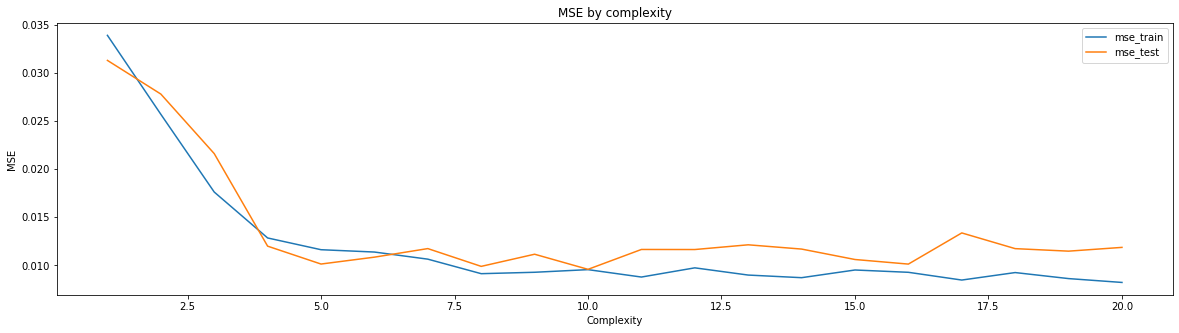

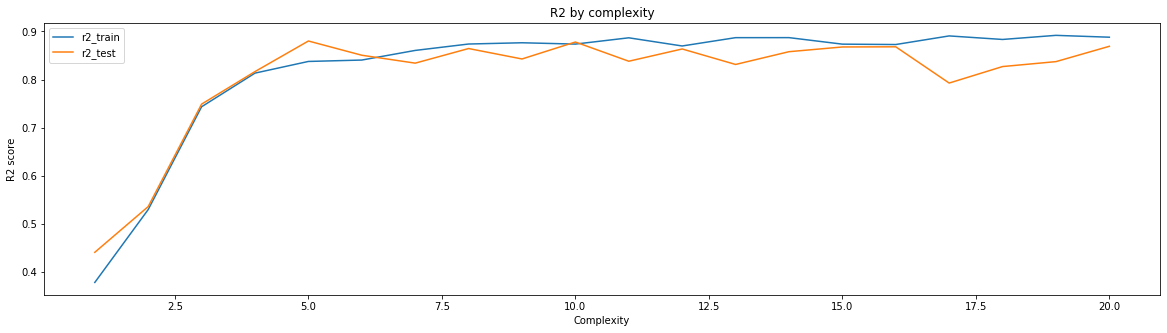

In [4]:
def simple_ols_run(
    x = (np.random.uniform(0, 1, 1000)), 
    y =  (np.random.uniform(0, 1, 1000)), 
    num_points = 1000, 
    complexity = 5, 
    noise = 0, 
    scale = True, 
    plot_mse = False, 
    plot_r2 = False):
    """
    Computes the simples ordinary least square based on the Franke Function
    
    Args:
        stuff
        
    Returns:
        ols_beta: The OLS
    """
    
    if num_points != len(x):
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
        
        
    MSE_train = []
    MSE_pred = []
    r2_train = []
    r2_pred = []
    
    all_ols_betas = []
    all_xtx_inv = []

    for complexity in range(1,complexity+1):

        #Trying not to sort the x and y's
        z = FrankeFunction(x, y, noise) # Target
        X = create_X(x, y, n=complexity)  # Data

        # True to z instead of y, and same with predictions: z_pred instead of y_pred
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        #scaler = MinMaxScaler(feature_range= [-1,1])
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
# Ridge: fit_intesect = False, da bryr vi oss ikke om intersect

        if scale:
            X_train = scaler_in.transform(X_train)
            X_test = scaler_in.transform(X_test)
            #X_train -= np.mean(X_train)
            #X_test -= np.mean(X_test)
            z_train = scale_z.transform(z_train)
            z_test = scale_z.transform(z_test)


        ols_beta = least_square(X_train, z_train)
        all_ols_betas.append(ols_beta)
        
        xtx = np.linalg.pinv(X_train.transpose().dot(X_train))
        all_xtx_inv.append(xtx)

        z_tilde = X_train.dot(ols_beta)
        z_pred = X_test.dot(ols_beta)


        mse_train = mean_squared_error(z_tilde, z_train)
        MSE_train.append(mse_train)
        mse_test = mean_squared_error(z_pred, z_test)
        MSE_pred.append(mse_test)

        r2_train.append(r2_score(z_tilde, z_train))
        r2_pred.append(r2_score(z_pred, z_test))
    
    if plot_mse:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = MSE_train, 
            y_values_test = MSE_pred,
            title = 'MSE by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'MSE',
            graph_label_train = 'mse_train',
            graph_label_test = 'mse_test'
        )

    if plot_r2:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = r2_train, 
            y_values_test = r2_pred,
            title = 'R2 by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'R2 score',
            graph_label_train = 'r2_train',
            graph_label_test = 'r2_test'
        )
    
    
    return all_ols_betas, all_xtx_inv

betas, xtx = simple_ols_run(num_points = 1000, complexity = 20, noise = 0.1, plot_mse = True, plot_r2 = True)


### Find confidence interval

In [5]:
def confidence_interval(beta, xtx_inv, confidence):
    """
    Calculates the confidence interval of our parameters beta
    
    Args:
        beta: our parameters
        xtx_inv: (pseudo) inverted of our design matrix transposed multiplied with the design matrix.
        confidence: confidence level
    Returns:
        confidence_interavl: the confidence interval for each of our parameters
    """
    diag_sqrt = np.sqrt(np.diag(xtx_inv))
    
    confidence_interval = [beta-confidence*diag_sqrt, beta+confidence*diag_sqrt]
        
    return np.array(confidence_interval)

betas, xtx = simple_ols_run(num_points = 100000, complexity = 5, noise = 10)
confidence_interval(betas[-1], xtx[-1], 1.96), betas[-1]

(array([[[ 0.00000000e+00, -1.32217432e+00, -1.32825219e+00,
          -6.32317291e+00, -4.95915023e+00, -6.33722888e+00,
          -1.41508627e+01, -1.04850057e+01, -1.05184647e+01,
          -1.41786775e+01, -1.47572493e+01, -1.12390785e+01,
          -1.05170104e+01, -1.12870767e+01, -1.47966789e+01,
          -5.78526953e+00, -5.01279505e+00, -4.90045757e+00,
          -4.89308233e+00, -5.03123817e+00, -5.80562770e+00],
         [ 5.02944628e+00,  3.70727196e+00,  3.70119409e+00,
          -1.29372663e+00,  7.02960443e-02, -1.30778261e+00,
          -9.12141642e+00, -5.45555943e+00, -5.48901842e+00,
          -9.14923122e+00, -9.72780302e+00, -6.20963226e+00,
          -5.48756411e+00, -6.25763042e+00, -9.76723266e+00,
          -7.55823253e-01,  1.66512321e-02,  1.28988707e-01,
           1.36363952e-01, -1.79189390e-03, -7.76181424e-01],
         [ 1.02915762e+00, -2.93016695e-01, -2.99094566e-01,
          -5.29401529e+00, -3.92999261e+00, -5.30807126e+00,
          -1.31217051e

## Exercise 2

### Plotting Figure 2.11

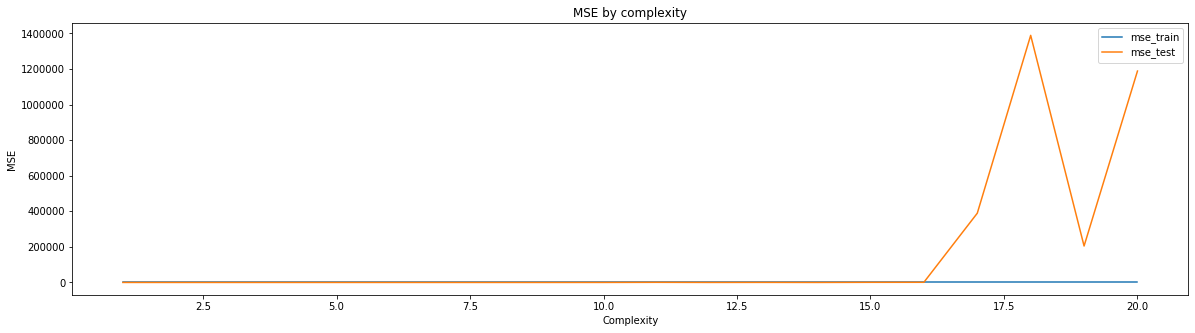

In [6]:
betas, xtx = simple_ols_run(num_points = 100, complexity = 20, noise = 1, plot_mse=True)

## Bias and variance explaination and interpretation

TODO

## Bias-variance trade-off analysis

### Bias-variance trade-off without bootstrap with constant data points

We see that we get no variance, and that the bias = error.

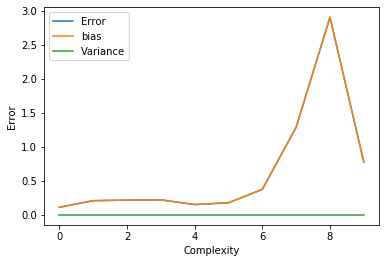

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
def bias_variance_analysis(reg_func, num_points, max_degree, lamb = 0):
    np.random.seed(10)
    # Make data
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.4) # Target
    
    # Aggregrate results
    error = np.zeros(max_degree)
    bias = np.zeros(max_degree)
    variance = np.zeros(max_degree)
    
    for complexity in range(max_degree):
        
        # Make design matrix
        X = create_X(x, y, n=complexity)
        
        # Split training data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        # Scaling the data
        """
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
        X_train = scaler_in.transform(X_train)
        X_test = scaler_in.transform(X_test)
        z_train = scale_z.transform(z_train)
        z_test = scale_z.transform(z_test)
        """
        # Find optimal beta
        beta_opt = reg_func(X_train, z_train, lamb)
        
        # Predict
        z_pred = X_test.dot(beta_opt)
        
        # Loss:
        mse_test = mean_squared_error(z_pred, z_test)
        
        # Aggregrate stats:
        error[complexity] = mse_test
        bias[complexity] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2)
        variance[complexity] = np.mean((z_pred - np.mean(z_pred, axis = 1, keepdims = True))**2)
        
    polydegree =  np.arange(max_degree)
    plt.plot(polydegree, error, label='Error')
    plt.plot(polydegree, bias, label='bias')
    plt.plot(polydegree, variance, label='Variance')
    plt.xlabel("Complexity")
    plt.ylabel("Error")
    
    plt.legend()
    plt.show()
    
    """
    stuff = np.add(bias,variance)
    print(variance)
    print(error - stuff)
    #print(variance)
    #print(np.mean(z_pred, axis = 1, keepdims = True))
    #print(z_pred.shape)
    #print(np.abs(z_pred-np.mean(z_pred, axis = 0, keepdims = True)))
    """
    
bias_variance_analysis(least_square, 100, 10)

## Bias-variance trade-off with bootstrap and varying number of datapoints

20


C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_l

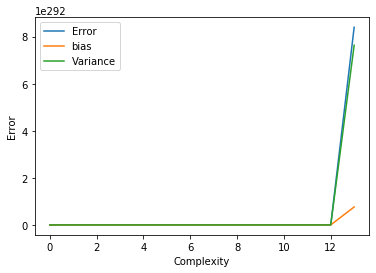

30


C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in square
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
C:\Users\willi\anaconda3\Lib\site-packages\ipykernel_launch

KeyboardInterrupt: 

In [12]:
def custom_mse_with_broadcast(y_pred, y_test):
    return np.mean((y_pred - y_test)**2)

def bias_variance_analysis_bootstrap(reg_func, num_points, max_degree, num_bootstraps, lamb = 0, plot = True, show_plot = True):
    # Make data
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.1) # Target
    
    # Aggregrate results
    error = np.zeros(max_degree)
    bias = np.zeros(max_degree)
    variance = np.zeros(max_degree)
    
    for complexity in range(max_degree):
        
        # Make design matrix
        X = create_X(x, y, n=complexity)
        
        # Split training data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        # Scaling the data
        
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
        X_train = scaler_in.transform(X_train)
        X_test = scaler_in.transform(X_test)
        z_train = scale_z.transform(z_train)
        z_test = scale_z.transform(z_test)
        
        # Bootstrap
        z_pred_aggregate = np.empty((z_test.shape[0], num_bootstraps+1))
        for boot_strap_number in range(1, num_bootstraps+1):
            x_sample, y_sample = resample(X_train, z_train)
            # Find optimal betas
            beta_opt = reg_func(x_sample, y_sample, lamb)
            # Predict
            z_pred = X_test.dot(beta_opt).ravel()
            # Aggregate the predictions
            z_pred_aggregate[:, boot_strap_number] = z_pred
        
        # Loss: Mean of all the bootstrap MSE's
        mse_test = np.mean(custom_mse_with_broadcast(z_pred_aggregate, z_test))
        
        # Aggregrate stats:
        error[complexity] = mse_test
        bias[complexity] = np.mean((z_test - np.mean(z_pred_aggregate, axis=1, keepdims=True))**2)
        variance[complexity] = np.mean((z_pred_aggregate - np.mean(z_pred_aggregate, axis = 1, keepdims = True))**2)
        
    
    if plot:  
        polydegree =  np.arange(max_degree)
        plt.plot(polydegree, error, label='Error')
        plt.plot(polydegree, bias, label='bias')
        plt.plot(polydegree, variance, label='Variance')
        plt.xlabel("Complexity")
        plt.ylabel("Error")
        plt.legend()
    if show_plot:
        plt.show()
            
    return error
    
for data_points in range(20, 100, 10):
    print(data_points)
    bias_variance_analysis_bootstrap(least_square, data_points, data_points, num_bootstraps = 10)  

# Exercise 3

## K-fold cross-validation

Scaling the data after we split the data, as if we split it before, then the we scale based on all the data instead of just training

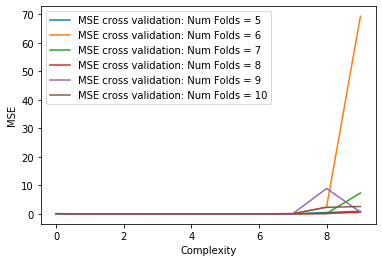

In [13]:
def kfold_custom(reg_func, num_points, num_splits, complexity, lamb = 0):
    
    # Create data
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.1) # Target
    
    X = create_X(x, y, n=complexity)

    # Initialize our kfold
    kfold = KFold(n_splits = num_splits)
    
    # Error
    mse_test_kfold = np.zeros(num_splits)
    
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Training split + scaling
        X_train = X[train_index] - np.mean(X[train_index])
        z_train = z[train_index] - np.mean(z[train_index])

        # Testing split + scaling
        X_test = X[test_index] - np.mean(X[test_index])
        z_test = z[test_index] - np.mean(z[test_index])
        
        # Optimal Betas
        beta_opt = reg_func(X_train, z_train, lamb)
        
        # Prediction
        z_pred = X_test.dot(beta_opt)
        
        mse_test_kfold[i] = mean_squared_error(z_test, z_pred)
        
        
    return np.mean(mse_test_kfold)

    
def cross_validation(reg_func, num_points, num_folds, max_complexity, lamb=0, plot = False):
    
    mse_per_complexity = np.zeros(max_complexity)
    
    for complexity in range(max_complexity):
        mse_per_complexity[complexity] = kfold_custom(reg_func, num_points, num_folds, complexity, lamb=lamb)
    
    if plot:
        polydegree =  np.arange(max_complexity)
        plt.plot(polydegree, mse_per_complexity, label='MSE cross validation: Num Folds = ' + str(num_folds))
        plt.xlabel("Complexity")
        plt.ylabel("MSE")
        plt.legend()
    
    return mse_per_complexity
        
def full_cross_valid(reg_func, num_points, min_fold, max_fold, max_complecity, lamb=0, plot = False, show_plot = False):
    
    for fold in range(min_fold, max_fold+1):
        cross_validation(reg_func, num_points, fold, max_complecity, lamb=lamb, plot=plot)

    if show_plot:
        plt.show()

full_cross_valid(least_square, 100, 5,10 , 10, plot = True, show_plot = True)


### Comparing with SKlearn

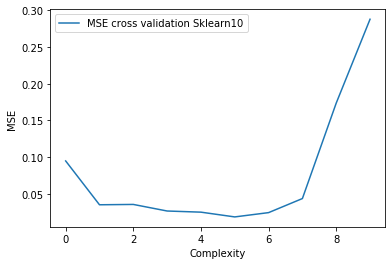

In [14]:
def cross_val_sklearn(num_points, num_folds, max_complexity, plot=False):
    estimated_mse_sklearn = np.zeros(max_complexity)
    
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.1) # Target
    
    for complexity in range(max_complexity):
        
        # Don't scale, just fit the raw data.
        linreg = LinearRegression(fit_intercept = False)
        
        X = create_X(x, y, n=complexity)
        
        kfold = KFold(n_splits = num_folds)

        estimated_mse_folds = cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold)

        estimated_mse_sklearn[complexity] = np.mean(-estimated_mse_folds)
        
    polydegree =  np.arange(max_complexity)
    plt.plot(polydegree, estimated_mse_sklearn, label='MSE cross validation Sklearn' + str(num_folds))
    plt.xlabel("Complexity")
    plt.ylabel("MSE")
    plt.legend()
    if plot:
        plt.show()

cross_val_sklearn(100, 10, 10, plot=True)

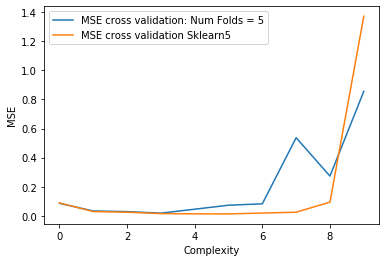

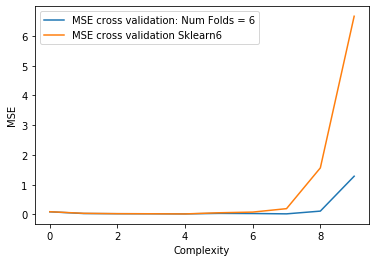

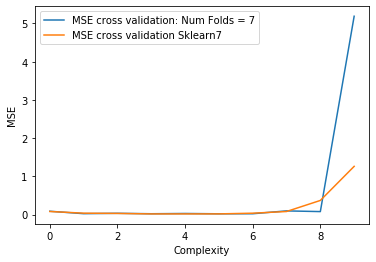

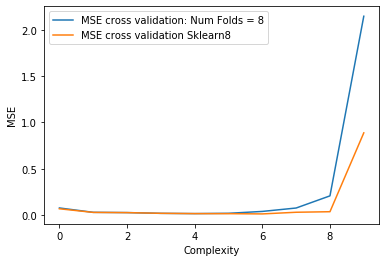

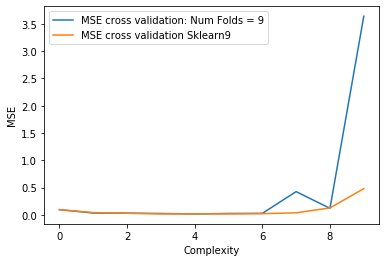

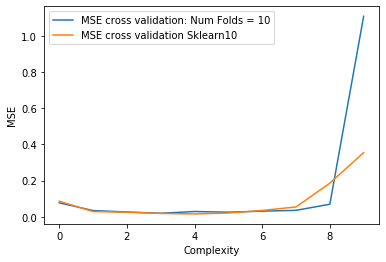

In [15]:
def compare_cross_valid_custom_vs_sklearn():
    for fold in range(5,11):
        full_cross_valid(least_square, 100, fold,fold,10, plot=True)
        cross_val_sklearn(100, fold, 10)
        plt.show()

compare_cross_valid_custom_vs_sklearn()

## Compare Cross validation vs. bootstrap for MSE for Least Square

In [ ]:
def compare_cv_with_booststrap(max_data_points, max_complexity):
    for fold in range(5,11):
        for num_data_points in range(20,max_data_points, 20):
            bootstrap_mse = bias_variance_analysis_bootstrap(least_square, num_data_points, max_complexity, num_data_points, plot = False) 
            cv_mse = cross_validation(least_square, num_data_points, fold, max_complexity)

            polydegree =  np.arange(max_complexity)
            plt.plot(polydegree, bootstrap_mse, label='MSE Boot_strap')
            plt.plot(polydegree, cv_mse, label='MSE CV num_folds: '+str(fold))
            plt.xlabel("Complexity")
            plt.ylabel("MSE: num_data_points: "+str(num_data_points))
            plt.legend()
            plt.show()

compare_cv_with_booststrap(100, 10)    

### Results 

commment comment comment...

Num datapoints: CV better for many, bootstrap better for few.

# Exercise 4

In this exercise we will:
* Write our own Ridge regression using singular value decomposition using the function pinv(), which uses the SVD.
* Perform the same bootstrap analysis as we did in exercise 2, using the same polynomials with different lambdas.
* Perform the same cross validation as in exercise 3, but with varying lambdas.
* Compare the results from Ridge (Ex. 4) with results from Least Square (Ex. 1-3).
* In general: Study the dependancies of lambads

Furthermore:
* Study the bias-variance trade-off for varying parameters lambda (for Ridge) using bootstrap.

### Custom Ridge Regression

In [ ]:
def Ridge(x_value,y_value, lamb):
    return np.linalg.pinv(x_value.T.dot(x_value) + lamb*np.identity(x_value.shape[1])).dot(x_value.T).dot(y_value)

## Bootstrap analysis (Ex. 2) using Ridge, with different lambads

In [ ]:
def bootstrap_analysis_ridge_lambas(nlambdas = 10):
    np.random.seed(10)
    lambdas = np.logspace(-4,4, nlambdas)
    for data_points in [20, 50, 100]:
        for lamb in lambdas:
            print(f"Lambda: {lamb}. Datapoints: {data_points}")
            bias_variance_analysis_bootstrap(Ridge, data_points, 10, data_points, lamb = lamb) 
            
bootstrap_analysis_ridge_lambas(5)

## What do we see?

We see that with a large regularization term, no matter the number of data points will have less to say. The regularization term squishes the parameters of the model so much that the feeding more won't do much to make a better fit (unless you feed a lot).

Remember that ridge shrinks larger weights -> they become more uniform. Too large regularization = no more weights.

## Cross validation analysis (Ex. 3) using Ridge, with different lambads

In [ ]:
def bootstrap_analysis_ridge_lambas(reg_func, num_points, min_fold, max_fold, max_complecity, nlambdas = 10, plot = False, show_plot = False):
    np.random.seed(10)
    lambdas = np.logspace(-4,4, nlambdas)
    for lamb in lambdas:
        plt.figure(figsize=(20,5))
        for fold in range(min_fold, max_fold+1):
            cross_validation(reg_func, num_points, fold, max_complecity, lamb=lamb, plot=plot)

        if show_plot:
            plt.title(f"Lambda: {lamb}")
            plt.show()
bootstrap_analysis_ridge_lambas(Ridge, 40, 5, 10, 10,  nlambdas = 10, plot= True, show_plot = True)

In [ ]:
def simple_ridge_run(
    x = (np.random.uniform(0, 1, 1000)), 
    y =  (np.random.uniform(0, 1, 1000)), 
    lamb = 0,
    num_points = 1000, 
    complexity = 5, 
    noise = 0, 
    scale = True, 
    plot_mse = False, 
    plot_r2 = False):
    """
    Computes the simples ordinary least square based on the Franke Function
    
    Args:
        stuff
        
    Returns:
        ols_beta: The OLS
    """
    
    if num_points != len(x):
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
        
        
    MSE_train = []
    MSE_pred = []
    r2_train = []
    r2_pred = []
    
    all_ols_betas = []
    all_xtx_inv = []

    for complexity in range(1,complexity+1):

        #Trying not to sort the x and y's
        z = FrankeFunction(x, y, noise) # Target
        X = create_X(x, y, n=complexity)  # Data

        # True to z instead of y, and same with predictions: z_pred instead of y_pred
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        #scaler = MinMaxScaler(feature_range= [-1,1])
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
# Ridge: fit_intesect = False, da bryr vi oss ikke om intersect

        if scale:
            X_train = scaler_in.transform(X_train)
            X_test = scaler_in.transform(X_test)
            #X_train -= np.mean(X_train)
            #X_test -= np.mean(X_test)
            z_train = scale_z.transform(z_train)
            z_test = scale_z.transform(z_test)


        ols_beta = Ridge(X_train, z_train, lamb)
        all_ols_betas.append(ols_beta)
        
        xtx = np.linalg.pinv(X_train.transpose().dot(X_train))
        all_xtx_inv.append(xtx)

        z_tilde = X_train.dot(ols_beta)
        z_pred = X_test.dot(ols_beta)


        mse_train = mean_squared_error(z_tilde, z_train)
        MSE_train.append(mse_train)
        mse_test = mean_squared_error(z_pred, z_test)
        MSE_pred.append(mse_test)

        r2_train.append(r2_score(z_tilde, z_train))
        r2_pred.append(r2_score(z_pred, z_test))
    
    if plot_mse:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = MSE_train, 
            y_values_test = MSE_pred,
            title = 'MSE by complexity. Lambda = '+str(lamb), 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'MSE',
            graph_label_train = 'mse_train',
            graph_label_test = 'mse_test'
        )

    if plot_r2:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = r2_train, 
            y_values_test = r2_pred,
            title = 'R2 by complexity. Lambda = '+str(lamb), 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'R2 score',
            graph_label_train = 'r2_train',
            graph_label_test = 'r2_test'
        )
    
    
    return all_ols_betas, all_xtx_inv


In [ ]:
betas, xtx = simple_ols_run(num_points = 1000, complexity = 20, noise = 0.1, plot_mse = True, plot_r2 = True)
lambdas = np.logspace(-4,2, 5)
for lamb in lambdas:
    betas, xtx = simple_ridge_run(num_points = 1000, lamb = lamb, complexity = 20, noise = 0.1, plot_mse = True, plot_r2 = True)
    